Projeto final de redes neurais, grupo:
-Luiz Eduardo Schmalz(lefvs)
-Pedro Calheiros(pca)
-Matheus Braga(mbb4)
-Henrique Melo(hcm)

Para iniciar vamos carregar o dataset e procurar pro outliers

In [59]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Carregar os dados do arquivo CSV
df = pd.read_csv('train.csv')

def detect_outliers(df):
    numeric_columns = df.select_dtypes(include=[np.number]).columns
    
    for column in numeric_columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Detectar outliers
        outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
        outlier_count = outliers.shape[0]
        
        # Printar o número de outliers e o valor máximo dos outliers
        if outlier_count > 0:
            max_outlier_value = outliers[column].max()
            print(f'Coluna {column}: {outlier_count} outliers detectados. Valor máximo do outlier: {max_outlier_value}')
        else:
            print(f'Coluna {column}: {outlier_count} outliers detectados.')
        
    return df

df = detect_outliers(df)

print(df.head())

Coluna Unnamed: 0: 0 outliers detectados.
Coluna id: 0 outliers detectados.
Coluna Age: 0 outliers detectados.
Coluna Flight Distance: 2291 outliers detectados. Valor máximo do outlier: 4983
Coluna Inflight wifi service: 0 outliers detectados.
Coluna Departure/Arrival time convenient: 0 outliers detectados.
Coluna Ease of Online booking: 0 outliers detectados.
Coluna Gate location: 0 outliers detectados.
Coluna Food and drink: 0 outliers detectados.
Coluna Online boarding: 0 outliers detectados.
Coluna Seat comfort: 0 outliers detectados.
Coluna Inflight entertainment: 0 outliers detectados.
Coluna On-board service: 0 outliers detectados.
Coluna Leg room service: 0 outliers detectados.
Coluna Baggage handling: 0 outliers detectados.
Coluna Checkin service: 12891 outliers detectados. Valor máximo do outlier: 1
Coluna Inflight service: 0 outliers detectados.
Coluna Cleanliness: 0 outliers detectados.
Coluna Departure Delay in Minutes: 14529 outliers detectados. Valor máximo do outlier: 1

Desse jeito detectamos duas colunas com outliers, a de departure delay in minute e arrival delay, vamos transfomar os outliers em médias das mesmas colunas, nota-se que a coluna flight distance vai continuar intacta pois os valores não foram considerados outliers.

In [60]:
def removing_outliers(df):
  
    numeric_columns = df.select_dtypes(include=[np.number]).columns
    

    if 'Departure Delay in Minutes' in numeric_columns and 'Arrival Delay in Minutes' in numeric_columns:
        for column in ['Departure Delay in Minutes', 'Arrival Delay in Minutes']:
            Q1 = df[column].quantile(0.25)
            Q3 = df[column].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            
            # Substituir os outliers pelos valores médios
            mean_value = df[column].mean()
            df[column] = np.where((df[column] < lower_bound) | (df[column] > upper_bound), mean_value, df[column])
        
    return df

# Exemplo de uso:
df = removing_outliers(df)

Agora vamos realizar o random oversampling para melhorar a precisão dos nossos futuros testes

In [61]:
from imblearn.over_sampling import RandomOverSampler
from collections import Counter

X = df.drop(columns=['satisfaction'])
y = df['satisfaction']

# Aplicar Random Oversampling no conjunto de treino
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X, y)

# Verificar as novas distribuições das classes
print(f'Distribuição antes do oversampling: {Counter(y)}')
print(f'Distribuição após o oversampling: {Counter(y_resampled)}')

# Verificar os dados resampled
print("X_resampled head:")
print(pd.DataFrame(X_resampled, columns=X.columns).head())

print("y_resampled head:")
print(y_resampled.head())

Distribuição antes do oversampling: Counter({'neutral or dissatisfied': 58879, 'satisfied': 45025})
Distribuição após o oversampling: Counter({'neutral or dissatisfied': 58879, 'satisfied': 58879})
X_resampled head:
   Unnamed: 0      id  Gender      Customer Type  Age   Type of Travel   
0           0   70172    Male     Loyal Customer   13  Personal Travel  \
1           1    5047    Male  disloyal Customer   25  Business travel   
2           2  110028  Female     Loyal Customer   26  Business travel   
3           3   24026  Female     Loyal Customer   25  Business travel   
4           4  119299    Male     Loyal Customer   61  Business travel   

      Class  Flight Distance  Inflight wifi service   
0  Eco Plus              460                      3  \
1  Business              235                      3   
2  Business             1142                      2   
3  Business              562                      2   
4  Business              214                      3   

   Depar

In [62]:
print("Dados resampled:")
df = pd.DataFrame(X_resampled, columns=X.columns)
df['satisfaction'] = y_resampled  # Adiciona a coluna target de volta ao dataframe
print(df.head())



Dados resampled:
   Unnamed: 0      id  Gender      Customer Type  Age   Type of Travel   
0           0   70172    Male     Loyal Customer   13  Personal Travel  \
1           1    5047    Male  disloyal Customer   25  Business travel   
2           2  110028  Female     Loyal Customer   26  Business travel   
3           3   24026  Female     Loyal Customer   25  Business travel   
4           4  119299    Male     Loyal Customer   61  Business travel   

      Class  Flight Distance  Inflight wifi service   
0  Eco Plus              460                      3  \
1  Business              235                      3   
2  Business             1142                      2   
3  Business              562                      2   
4  Business              214                      3   

   Departure/Arrival time convenient  ...  Inflight entertainment   
0                                  4  ...                       5  \
1                                  2  ...                       1   


In [63]:
# Dividir o dataset com base na coluna 'satisfaction'
satisfied_df = df[df['satisfaction'] == 'satisfied']
non_satisfied_df = df[df['satisfaction'] == 'neutral or dissatisfied']

# Verificar os resultados
print("Satisfied DataFrame:")
print(satisfied_df.head())

print("Non Satisfied DataFrame:")
print(non_satisfied_df.head())

Satisfied DataFrame:
    Unnamed: 0      id  Gender   Customer Type  Age   Type of Travel   
2            2  110028  Female  Loyal Customer   26  Business travel  \
4            4  119299    Male  Loyal Customer   61  Business travel   
7            7   96462  Female  Loyal Customer   52  Business travel   
13          13   83502    Male  Loyal Customer   33  Personal Travel   
16          16   71142  Female  Loyal Customer   26  Business travel   

       Class  Flight Distance  Inflight wifi service   
2   Business             1142                      2  \
4   Business              214                      3   
7   Business             2035                      4   
13       Eco              946                      4   
16  Business             2123                      3   

    Departure/Arrival time convenient  ...  Inflight entertainment   
2                                   2  ...                       5  \
4                                   3  ...                       3   

Agora vamos checar se há valores nulos no nosso dataset

In [64]:

def check_and_fill_missing_values(df):
    missing_values = df.isnull().sum()
    missing_values = missing_values[missing_values > 0]
    
    if missing_values.empty:
        print("Não há valores não preenchidos no dataset.")
    else:
        print("Valores não preenchidos por coluna:")
        for column, count in missing_values.items():
            print(f'{column}: {count} valores não preenchidos')
            # Substituir valores não preenchidos pela média da coluna
            mean_value = df[column].mean()
            df[column].fillna(mean_value, inplace=True)
            print(f'Valores não preenchidos na coluna {column} foram substituídos pela média: {mean_value}')
    
    return df

satisfied_df = check_and_fill_missing_values(satisfied_df)
non_satisfied_df = check_and_fill_missing_values(non_satisfied_df) 


Valores não preenchidos por coluna:
Arrival Delay in Minutes: 170 valores não preenchidos
Valores não preenchidos na coluna Arrival Delay in Minutes foram substituídos pela média: 4.664964689474531
Valores não preenchidos por coluna:
Arrival Delay in Minutes: 182 valores não preenchidos
Valores não preenchidos na coluna Arrival Delay in Minutes foram substituídos pela média: 6.3063254853030095


C:\Users\luize\AppData\Local\Temp\ipykernel_19728\3037859522.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column].fillna(mean_value, inplace=True)


Agora vamos plotar graficos para entender melhor as variaveis antes de muda-las

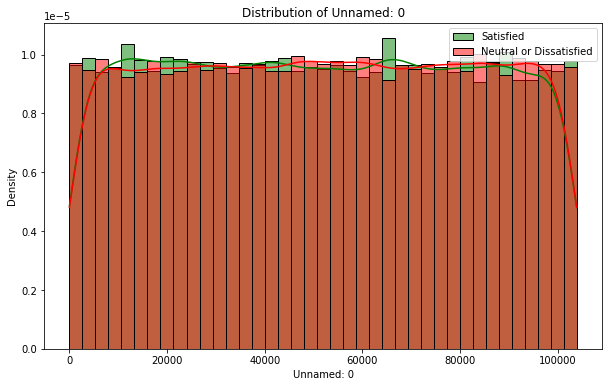

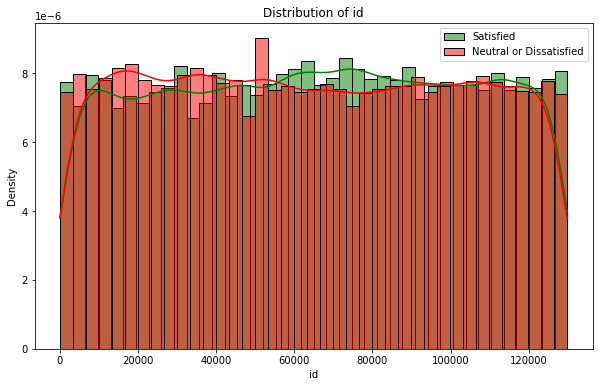

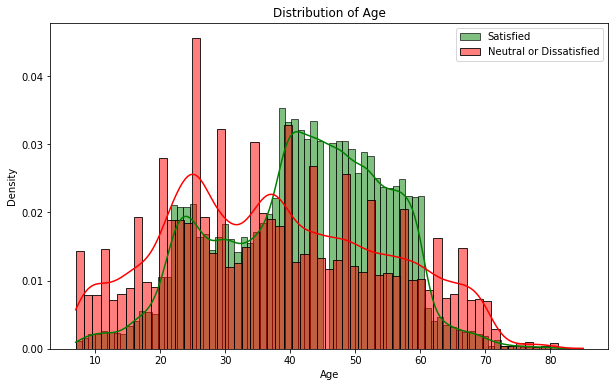

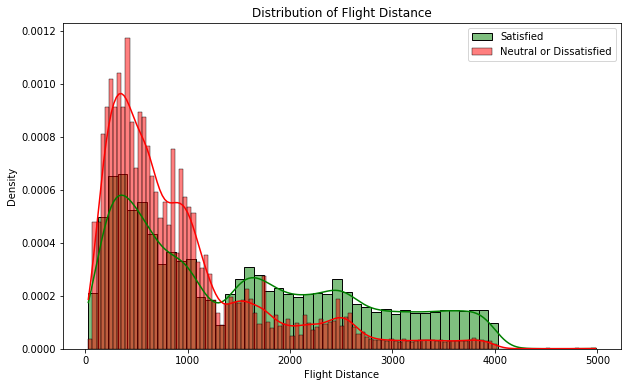

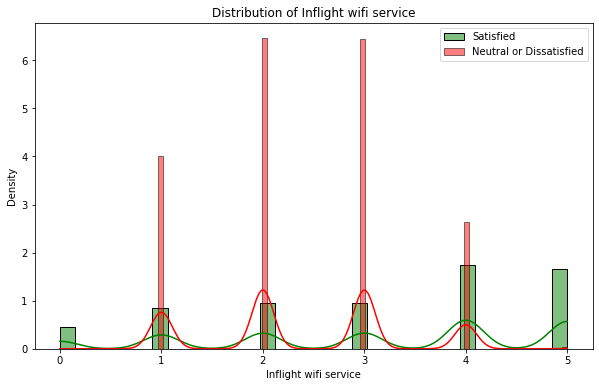

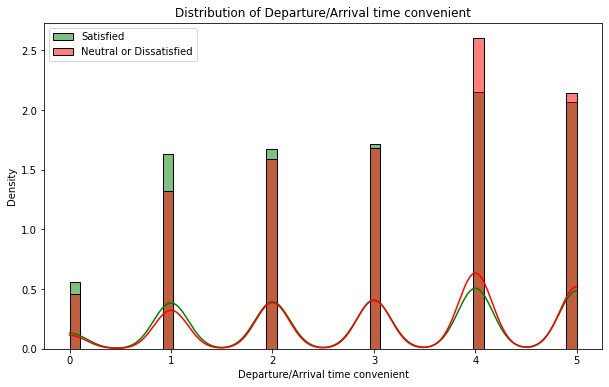

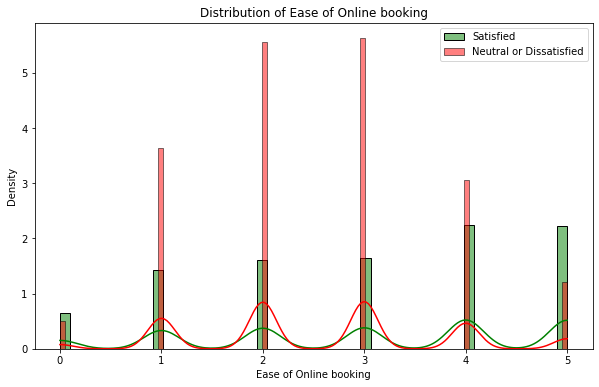

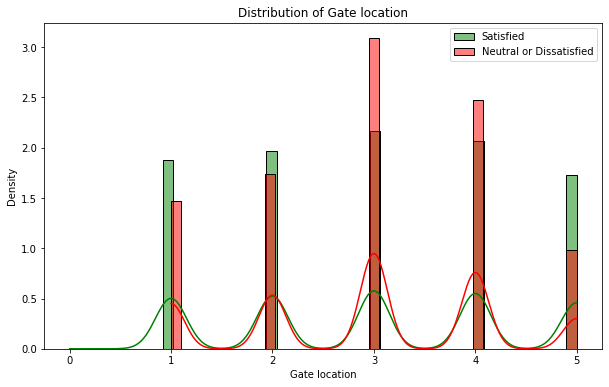

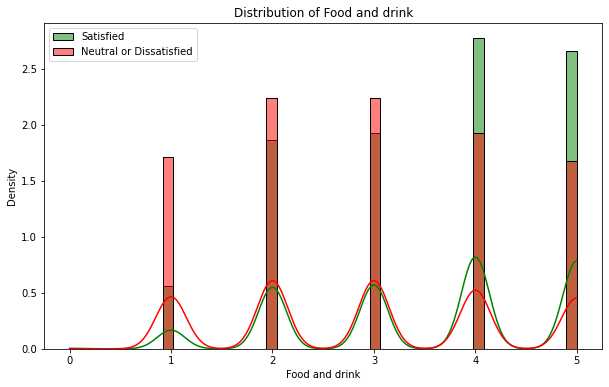

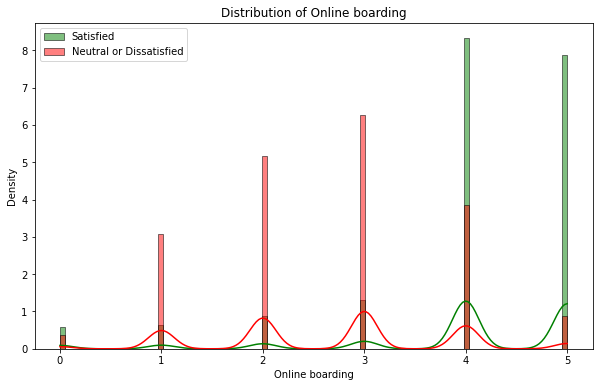

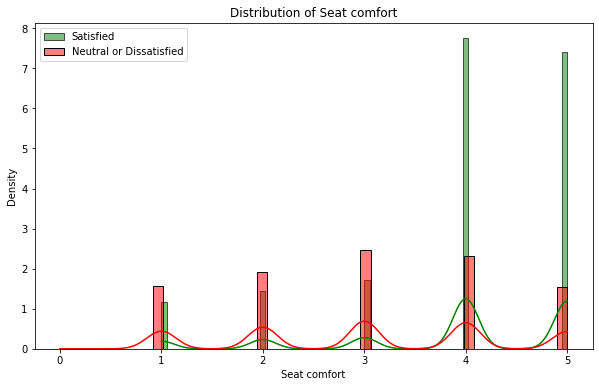

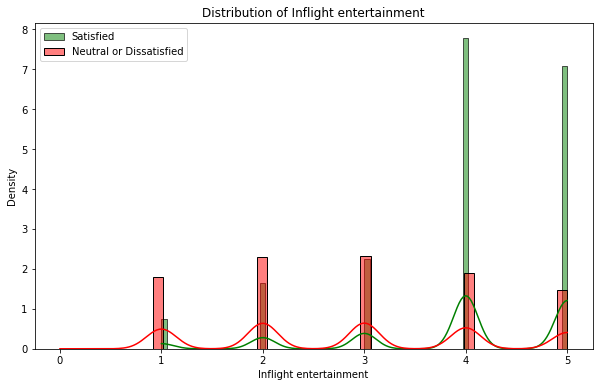

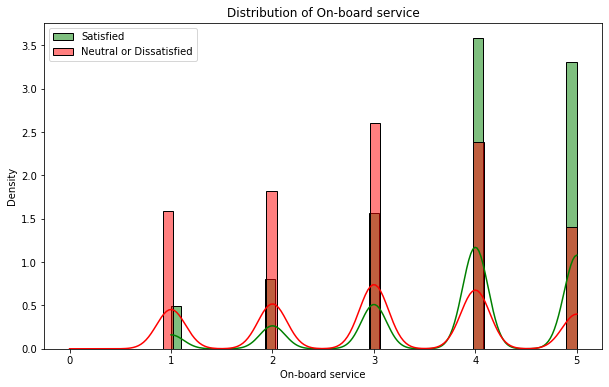

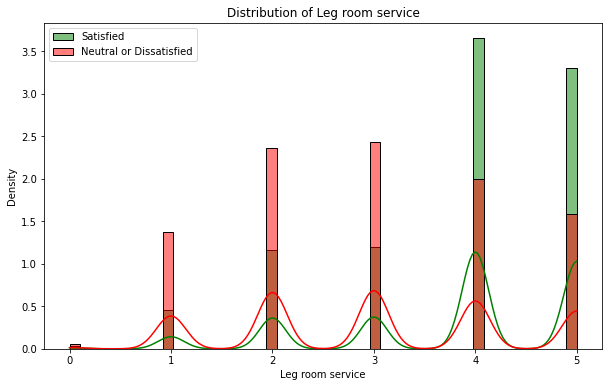

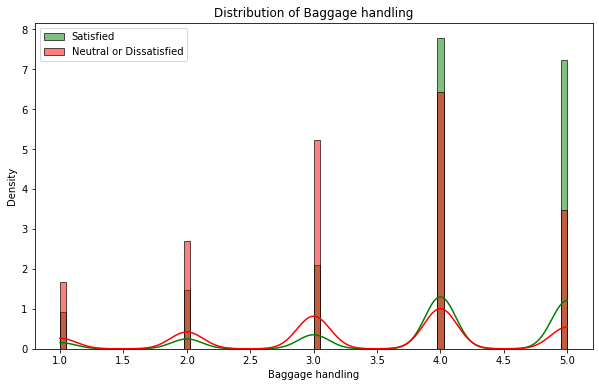

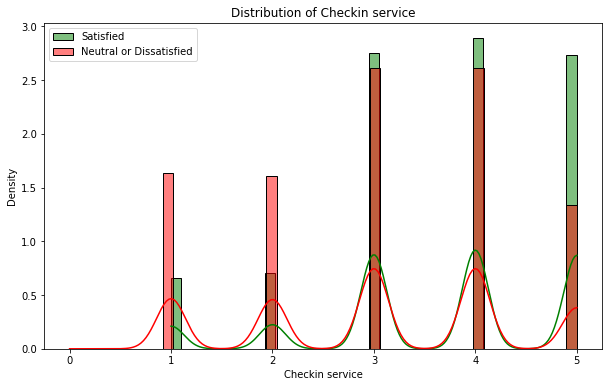

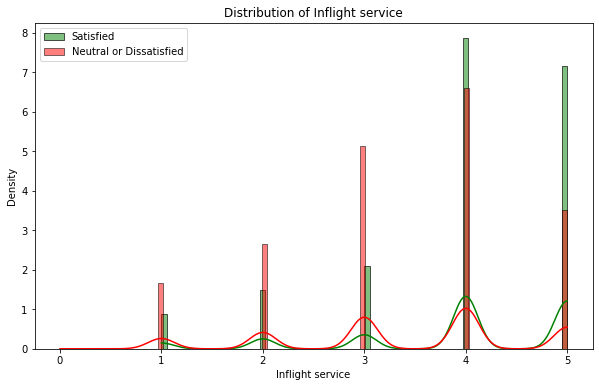

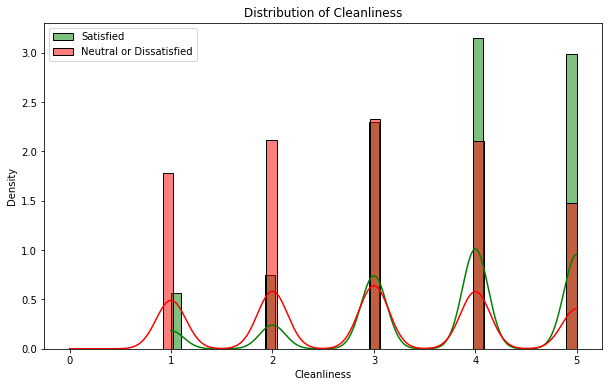

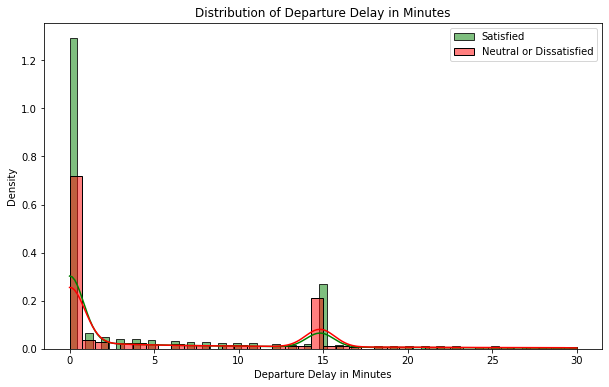

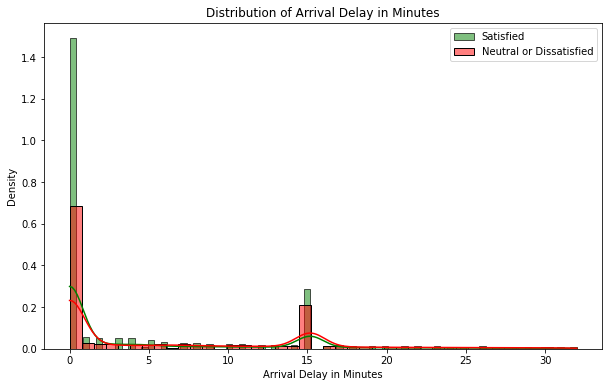

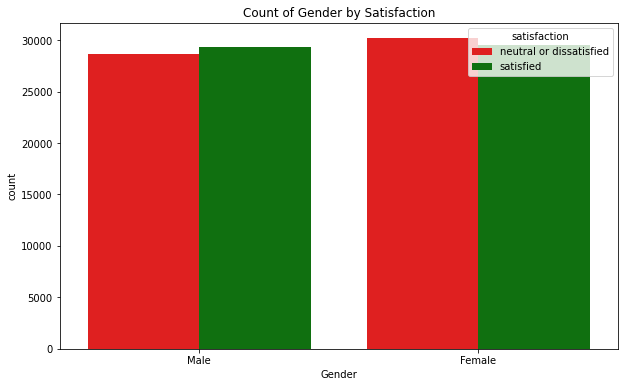

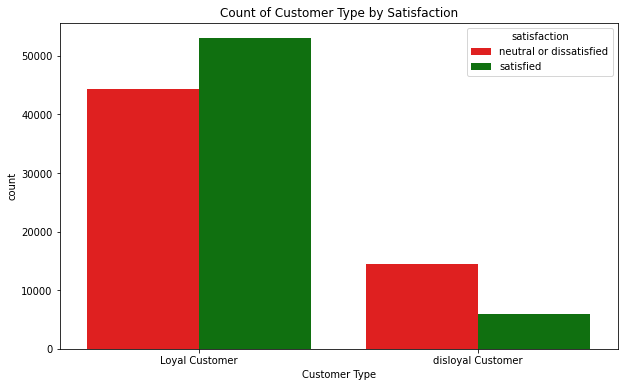

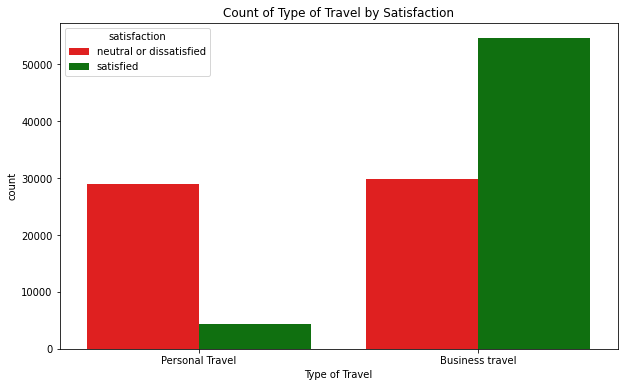

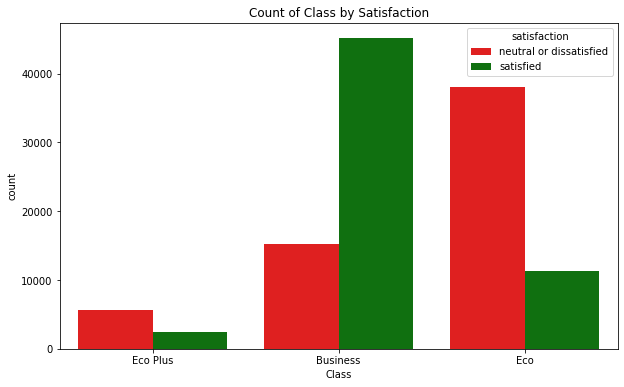

In [65]:
numeric_columns = df.select_dtypes(include=[np.number]).columns
for column in numeric_columns:
    plt.figure(figsize=(10, 6))
    sns.histplot(satisfied_df[column], color='green', label='Satisfied', kde=True, stat="density")
    sns.histplot(non_satisfied_df[column], color='red', label='Neutral or Dissatisfied', kde=True, stat="density")
    plt.title(f'Distribution of {column}')
    plt.legend()
    plt.show()

# Plotar a contagem das variáveis categóricas para cada classe
categorical_columns = df.select_dtypes(include=[object]).columns
categorical_columns = categorical_columns.drop('satisfaction')
for column in categorical_columns:
    plt.figure(figsize=(10, 6))
    sns.countplot(data=df, x=column, hue='satisfaction', palette={'satisfied': 'green', 'neutral or dissatisfied': 'red'})
    plt.title(f'Count of {column} by Satisfaction')
    plt.show()

Agora vamos tratar alguns dados, vamos dividir a distancia do voo em 3 colunas e preenche-las com 0 ou 1 a depender da classe, faremos a mesma coisa quanto a idade da pessoa. Pesquisamos quais valores em milhas configuram um voo de pequena, media ou longa distância. Também vamos mapear todas outras variaveis em binario

In [66]:
def categorize_age(df):
    # Inicializar as novas colunas com 0
    df['Criança'] = 0
    df['Adulto'] = 0
    df['Idoso'] = 0

    # Preencher as colunas com 1 de acordo com a faixa etária
    df.loc[df['Age'] < 18, 'Criança'] = 1
    df.loc[(df['Age'] >= 18) & (df['Age'] < 60), 'Adulto'] = 1
    df.loc[df['Age'] >= 60, 'Idoso'] = 1

    return df

def categorize_flyght(df):
    # Inicializar as novas colunas com 0
    df['Curto'] = 0
    df['Médio'] = 0
    df['Longo'] = 0

    # Preencher as colunas com 1 de acordo com a duração do voo
    df.loc[df['Flight Distance'] < 935, 'Curto'] = 1
    df.loc[(df['Flight Distance'] >= 935) & (df['Flight Distance'] < 2485), 'Médio'] = 1
    df.loc[df['Flight Distance'] >= 2485, 'Longo'] = 1

    return df

def categorize_departure_delay(df):
    # Inicializar as novas colunas com 0
    df['Pouco Atraso na saida'] = 0
    df['Atraso na saida'] = 0

    # Preencher as colunas com 1 de acordo com a duração do voo
    df.loc[df['Departure Delay in Minutes'] <= 15, 'Pouco Atraso na saida'] = 1
    df.loc[df['Departure Delay in Minutes'] > 15, 'Atraso na saida'] = 1

    return df

def categorize_arrival_delay(df):
    # Inicializar as novas colunas com 0
    df['Pouco Atraso na chegada'] = 0
    df['Atraso na chegada'] = 0

    # Preencher as colunas com 1 de acordo com a duração do voo
    df.loc[df['Arrival Delay in Minutes'] <= 15, 'Pouco Atraso na chegada'] = 1
    df.loc[df['Arrival Delay in Minutes'] > 15, 'Atraso na chegada'] = 1

    return df

satisfied_df = categorize_departure_delay(satisfied_df)
non_satisfied_df = categorize_departure_delay(non_satisfied_df)

satisfied_df = categorize_arrival_delay(satisfied_df)
non_satisfied_df = categorize_arrival_delay(non_satisfied_df)

satisfied_df = categorize_age(satisfied_df)
non_satisfied_df = categorize_age(non_satisfied_df)

satisfied_df = categorize_flyght(satisfied_df)
non_satisfied_df = categorize_flyght(non_satisfied_df)

satisfied_df.drop(columns=['Age', 'Flight Distance' , 'Departure Delay in Minutes', 'Arrival Delay in Minutes'], inplace=True)
non_satisfied_df.drop(columns=['Age', 'Flight Distance', 'Departure Delay in Minutes', 'Arrival Delay in Minutes'], inplace=True)

#customer
map_customer = {'Loyal Customer': 1, 'disloyal Customer': 0}
#type of travel
map_travel = {'Business travel': 1, 'Personal Travel': 0}
#class
map_class = {'Business': 1, 'Eco': 0, 'Eco Plus': 2}
#gender
map_genero = {'Male': 1, 'Female': 0}
#satisfaction
map_satisfaction = {'satisfied': 1, 'neutral or dissatisfied': 0}

#dropando primeiras duas colunas
satisfied_df = satisfied_df.drop([satisfied_df.columns[0],'id'], axis=1)
non_satisfied_df = non_satisfied_df.drop([non_satisfied_df.columns[0],'id'], axis=1)

#agora aplicar esses outros mapeamentos aos datasets
satisfied_df['Gender'] = satisfied_df['Gender'].map(map_genero)
satisfied_df['Customer Type'] = satisfied_df['Customer Type'].map(map_customer)
satisfied_df['Type of Travel'] = satisfied_df['Type of Travel'].map(map_travel)
satisfied_df['Class'] = satisfied_df['Class'].map(map_class)
satisfied_df['satisfaction'] = satisfied_df['satisfaction'].map(map_satisfaction)
non_satisfied_df['Gender'] = non_satisfied_df['Gender'].map(map_genero)
non_satisfied_df['Customer Type'] = non_satisfied_df['Customer Type'].map(map_customer)
non_satisfied_df['Type of Travel'] = non_satisfied_df['Type of Travel'].map(map_travel)
non_satisfied_df['Class'] = non_satisfied_df['Class'].map(map_class)    
non_satisfied_df['satisfaction'] = non_satisfied_df['satisfaction'].map(map_satisfaction)

print(satisfied_df.head())
print(non_satisfied_df.head())


    Gender  Customer Type  Type of Travel  Class  Inflight wifi service   
2        0              1               1      1                      2  \
4        1              1               1      1                      3   
7        0              1               1      1                      4   
13       1              1               0      0                      4   
16       0              1               1      1                      3   

    Departure/Arrival time convenient  Ease of Online booking  Gate location   
2                                   2                       2              2  \
4                                   3                       3              3   
7                                   3                       4              4   
13                                  2                       4              3   
16                                  3                       3              3   

    Food and drink  Online boarding  ...  Pouco Atraso na saida   
2

C:\Users\luize\AppData\Local\Temp\ipykernel_19728\1307612577.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Pouco Atraso na saida'] = 0
C:\Users\luize\AppData\Local\Temp\ipykernel_19728\1307612577.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Atraso na saida'] = 0
C:\Users\luize\AppData\Local\Temp\ipykernel_19728\1307612577.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the c

Antes de normalizar, vamos fazer o tratamento de dados do conjunto de testes, para assim poder normalizar ele com base nos parametros do conjunto de treino

In [67]:
test_df =pd.read_csv('test.csv')

test_df = categorize_departure_delay(test_df)
test_df = categorize_arrival_delay(test_df)
test_df = categorize_age(test_df)
test_df = categorize_age(test_df)
test_df = categorize_flyght(test_df)
test_df.drop(columns=['Age', 'Flight Distance' , 'Departure Delay in Minutes', 'Arrival Delay in Minutes'], inplace=True)

#dropando primeiras duas colunas
test_df = test_df.drop([test_df.columns[0],'id'], axis=1)

#agora aplicar esses outros mapeamentos aos datasets
test_df['Gender'] = test_df['Gender'].map(map_genero)
test_df['Customer Type'] = test_df['Customer Type'].map(map_customer)
test_df['Type of Travel'] = test_df['Type of Travel'].map(map_travel)
test_df['Class'] = test_df['Class'].map(map_class)
test_df['satisfaction'] = test_df['satisfaction'].map(map_satisfaction)

print(test_df.head())

   Gender  Customer Type  Type of Travel  Class  Inflight wifi service   
0       0              1               1      0                      5  \
1       0              1               1      1                      1   
2       1              0               1      0                      2   
3       1              1               1      1                      0   
4       0              1               1      0                      2   

   Departure/Arrival time convenient  Ease of Online booking  Gate location   
0                                  4                       3              4  \
1                                  1                       3              1   
2                                  0                       2              4   
3                                  0                       0              2   
4                                  3                       4              3   

   Food and drink  Online boarding  ...  Pouco Atraso na saida   
0             

In [68]:
datatreated_train = pd.concat([satisfied_df, non_satisfied_df], ignore_index=True)


def normalize_columns(df, columns, min_values=None, max_values=None):
    if min_values is None or max_values is None:
        # Calcular min-max apenas se os valores não forem fornecidos
        min_values = df[columns].min()
        max_values = df[columns].max()
    
    # Aplicar normalização min-max
    df[columns] = (df[columns] - min_values) / (max_values - min_values)
    
    return df, min_values, max_values

columns_to_normalize = ['Class', 'Inflight wifi service', 'Departure/Arrival time convenient', 'Ease of Online booking', 'Gate location', 'Food and drink', 'Online boarding', 
                        'Seat comfort', 'Inflight entertainment', 'On-board service', 'Leg room service', 'Baggage handling', 'Checkin service', 'Inflight service', 'Cleanliness']

datatreated_train, min_values, max_values = normalize_columns(datatreated_train, columns_to_normalize)
print(min_values)
print(max_values)

# Normalizar DataFrame de teste usando os mesmos parâmetros de treino
test_df[columns_to_normalize] = (test_df[columns_to_normalize] - min_values) / (max_values - min_values)

# Exibir os resultados
print("DataFrame de treino normalizado:")
print(datatreated_train.head())
print("\nDataFrame de teste normalizado:")
print(test_df.head())

Class                                0
Inflight wifi service                0
Departure/Arrival time convenient    0
Ease of Online booking               0
Gate location                        0
Food and drink                       0
Online boarding                      0
Seat comfort                         0
Inflight entertainment               0
On-board service                     0
Leg room service                     0
Baggage handling                     1
Checkin service                      0
Inflight service                     0
Cleanliness                          0
dtype: int64
Class                                2
Inflight wifi service                5
Departure/Arrival time convenient    5
Ease of Online booking               5
Gate location                        5
Food and drink                       5
Online boarding                      5
Seat comfort                         5
Inflight entertainment               5
On-board service                     5
Leg room ser

Agora finalizamos o tratamento de dados do dataset de treino, vamos salvar os datasets e começar nossos experimentos.

In [69]:
test_df.to_csv('test_normalized.csv', index=False)
datatreated_train.to_csv('train_normalized.csv', index=False)